In [37]:
import pandas as pd
import numpy as np
import math
import glob
import scipy
import os.path as op
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 

%matplotlib inline

In [2]:
# get list of data files to process
data_files = glob.glob('data/*txt')

In [3]:
# CONSTANTS NECESSARY FOR MAKING SENSE OF THE DATA FILES
col_names = ['stim', 'cond', 'trial', 'amountSS',
             'amountLL', 'delayLL', 'choice', 'space','pct_diff']
stim = { 1:'Pre', 2:'TMS', 3:'Sham' }
cond = { 1:'Ctrl', 2:'Hidden Zero', 3:'Magnitude' }
choice = { 1:'SS', 0:'LL'}

In [4]:
all_data = []
for f in data_files:
    data = pd.read_csv(f, delimiter = '\t', header = None,
                      names = col_names, index_col = False)
    
    data['choice_binary'] = data['choice']
    data['choice'] = [choice[x] for x in data['choice']]
    data['cond'] = [cond[x] for x in data['cond']]
    data['stim'] = [stim[x] for x in data['stim']]
    
    data = data[['stim', 'cond', 'trial', 'amountSS', 
                 'amountLL', 'delayLL', 'choice','choice_binary','pct_diff']]
    
    data['hemi'] = f.split('/')[1].split('s')[0]
    data['sub'] = f.split('.')[0][-2:]
     
    all_data.append(data)
all_data = pd.concat(all_data)

In [5]:
def find_K(A1,A2,d1,d2):
    return (A2/A1 - 1)*1.0 / (d2 - (A2/A1)*d1)

In [6]:
#find k_eq for each choice
for row in set(all_data.index):
    k_eq = find_K(all_data.loc[row,'amountSS'].values[0],
       all_data.loc[row,'amountLL'].values[0],
       0,
       all_data.loc[row,'delayLL'].values[0])
    

    all_data.loc[row,'k_eq'] = k_eq

#drop trial level
all_data = all_data.reset_index().set_index(['sub','cond','stim','hemi']).sort_index()

In [7]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*d)

In [8]:
def errf(params,sub_data):
    #get params and bound on [0,1]
    k,m = params
    k = scipy.stats.logistic.cdf(k)
    m = scipy.stats.logistic.cdf(m)*20
    LL = 0
    for trial in range(sub_data.shape[0]):
        SV_SS = hyperbolic(sub_data.loc[trial,'amountSS'],
                            0, #delayed rewards available now
                            k)
        SV_LL = hyperbolic(sub_data.loc[trial,'amountLL'],
                            sub_data.loc[trial,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*(SV_SS-SV_LL)*m) )
        if sub_data.loc[trial,'choice'] == 'LL':
            p = 1-p
            
        if p < 1e-100:
            p = 1e-100
            
        LL += np.log(p)
    return LL*-1 #minimize negative log likelihood

In [9]:
in_tuples = list(set(all_data.index))

In [10]:
def run_data(in_tup):
    #get the data for this experiment
    sub_data = all_data.loc[in_tup].reset_index().copy()
    sub, exp, tms, hemi = in_tup
    
    #check to see if they made all LL or all SS choices and set k appropriately
    if sum(sub_data['choice'] == 'LL') == sub_data.shape[0]: #all larger later
        k = min(sub_data['k_eq'])
        return in_tup,k
    elif sum(sub_data['choice'] == 'SS') == sub_data.shape[0]: #all SS
        k = max(sub_data['k_eq'])
        return in_tup,k
    
    #run minimization
    else:
        k_init = scipy.stats.logistic.ppf(sub_data['k_eq'].mean())
        m_init = -5
        if exp == 'Magnitude':
            m_init = scipy.stats.logistic.cdf(m_init)/10.0
            m_init = scipy.stats.logistic.ppf(m_init)
        params = [k_init,m_init]
        minimizer_kwargs = {"method": 'CG', 'args':(sub_data)}
        try:
            res = basinhopping(errf, params, minimizer_kwargs=minimizer_kwargs,niter=50)
        except:
            return (in_tup,'Failed')
        return (in_tup,res)

In [11]:
pool = multiprocessing.Pool(54)
res = pool.map(run_data,in_tuples)
pool.terminate()
pool.join()

In [12]:
results_df = {'ll':[], 'k':[], 'm':[],'sub':[],'exp':[],'hemi':[],'tms':[]}
for x in res:
    in_tup,o = x
    sub, exp, tms, hemi = in_tup
    if o == 'Failed':
        print in_tup
        
    else:
        results_df['ll'].append(o.fun*-1)
        results_df['k'].append(scipy.stats.logistic.cdf(o.x[0]))
        results_df['m'].append(scipy.stats.logistic.cdf(o.x[1])*20)
        results_df['sub'].append(sub)
        results_df['exp'].append(exp)
        results_df['tms'].append(tms)
        results_df['hemi'].append(hemi)
results_df = pd.DataFrame(results_df)
results_df['logk'] = np.log(results_df['k'])*-1
results_df.to_csv(op.abspath('./k_fits.csv'), index = False)
results_df = results_df.set_index(['sub','exp','tms','hemi'])

In [19]:
results_df = pd.read_csv(op.abspath('./k_fits.csv'))


In [41]:
# #compute LLRT relative to to coin flip model
# for in_tup in in_tuples:
#     sub_data = all_data.loc[in_tup].reset_index().copy()
    
#     null_ll = np.log(.5)*sub_data.shape[0]
#     ll = results_df.loc[in_tup,'ll']
#     ratio = 2*(ll - null_ll)
#     test_stat = stats.chi2.sf(ratio,2)
    
#     results_df.loc[in_tup,'chi'] = test_stat

In [52]:
#average over hemispheres
# r = results_df.groupby(['exp','tms','sub']).mean().reset_index()

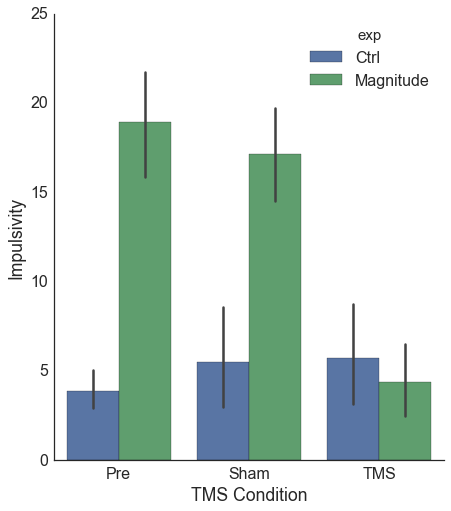

In [53]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (7, 8)})
sns.set_style("white")
r = r[r['exp'] != 'Hidden Zero']
r['TMS Condition'] = r['tms']
sns.barplot(x = 'TMS Condition', y = 'logk',hue = 'exp' , data = r)
plt.ylabel('Impulsivity')
sns.despine()
# plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/Magnitude.png', dpi = 300)

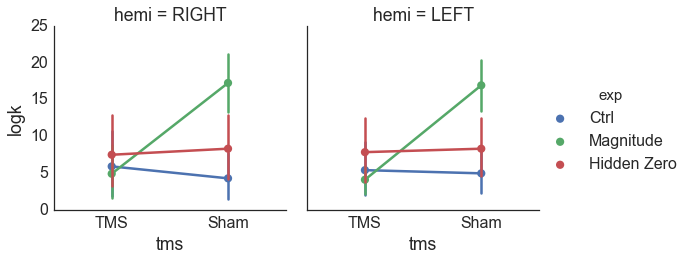

In [66]:
pre = results_df[results_df['tms'] !='Pre']
test = pre[pre['exp'] != '']
sns.factorplot(x = 'tms', y = 'logk',hue = 'exp', col = 'hemi', data = test)


In [67]:
mag = pre[pre['exp'] != 'Hidden Zero']


In [79]:
# model_str = 'logk ~ tms*exp*hemi'
# mixedfx = smf.mixedlm(model_str, mag, groups = mag['sub'])    
# mixedfx = mixedfx.fit()
# print mixedfx.summary()

In [77]:
mag['sub_id'] = [str(x) + y for x,y in zip(mag['sub'],mag['hemi'])]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
model = afex.aov_ez('sub_id', 'logk', data = mag, within=['exp','tms'], between = ['hemi'])
print(model)
print model.rx2('Anova')

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE         F   ges p.value
1         hemi 1, 25 45.29      0.03 .0003     .85
2          exp 1, 25 54.21 15.72 ***   .16   .0005
3     hemi:exp 1, 25 54.21      0.05 .0006     .82
4          tms 1, 25 49.79 17.85 ***   .17   .0003
5     hemi:tms 1, 25 49.79      0.09  .001     .76
6      exp:tms 1, 25 29.08 42.41 ***   .22  <.0001
7 hemi:exp:tms 1, 25 29.08      0.03 .0002     .87

Sphericity correction method: GG 


Type III Repeated Measures MANOVA Tests: Pillai test statistic
             Df test stat approx F num Df den Df    Pr(>F)    
(Intercept)   1   0.85788  150.902      1     25 4.342e-12 ***
hemi          1   0.00137    0.034      1     25 0.8546992    
exp           1   0.38600   15.717      1     25 0.0005428 ***
hemi:exp      1   0.00209    0.052      1     25 0.8207322    
tms           1   0.41659   17.851      1     25 0.0002775 ***
hemi:tms      1   0.00375    0.094      1     25 0.7614744    
exp:tms 

//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: hemi

  warnings.warn(x, RRuntimeWarning)


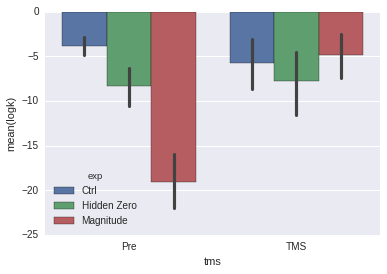

In [144]:
sham = r[r['tms'] !='Pre']
test = pre[pre['exp'] != '']
sns.barplot(x = 'tms', y = 'logk',hue = 'exp' , data = test)


# Percent SS Analysis

In [247]:
perc_df =all_data.reset_index().groupby(['sub','stim','cond']).mean().reset_index()
perc_df['choice_binary_logit'] = [scipy.special.logit(x) for x in perc_df['choice_binary']]

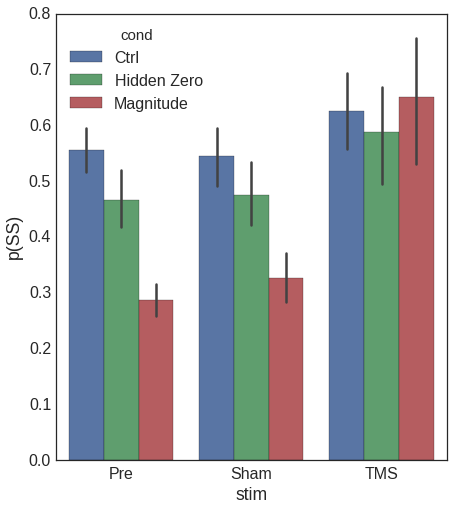

In [249]:
sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = perc_df)
plt.ylabel('p(SS)')

### Sham

In [250]:
#Mixed model relative to Sham
sub_df = perc_df[perc_df['stim'] !='Pre']
model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, sub_df, groups = sub_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                   Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    choice_binary_logit
No. Observations:    90         Method:                REML               
No. Groups:          15         Scale:                 0.3356             
Min. group size:     6          Likelihood:            -91.4188           
Max. group size:     6          Converged:             Yes                
Mean group size:     6.0                                                  
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.189    0.185  1.021 0.307 -0.173  0.551
stim[T.TMS]                      0.375    0.212  1.774 0.076 -0.039  0.790
cond[T.Hidden Zero]             -0.290    0.212 -1.372 0.170 -0.705  0.124
cond[T.Magnitude]               -0.942    0

In [251]:
s = sub_df.set_index(['cond','stim','sub']).copy()
s.loc[('Magnitude','TMS'),'choice_binary'] = (s.loc[('Magnitude','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Hidden Zero','TMS'),'choice_binary'] = (s.loc[('Hidden Zero','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Magnitude','Sham'),'choice_binary'] = (s.loc[('Magnitude','Sham'),'choice_binary'] \
    - s.loc[('Ctrl','Sham'),'choice_binary']).values
s.loc[('Hidden Zero','Sham'),'choice_binary'] = (s.loc[('Hidden Zero','Sham'),'choice_binary'] \
    - s.loc[('Ctrl','Sham'),'choice_binary']).values

s = s.reset_index()
s = s[s['cond'] != 'Ctrl']

# sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = s.reset_index())

model_str = 'choice_binary ~ stim*cond'
mixedfx = smf.mixedlm(model_str, s, groups = s['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     choice_binary
No. Observations:      60          Method:                 REML         
No. Groups:            15          Scale:                  0.0116       
Min. group size:       4           Likelihood:             35.6399      
Max. group size:       4           Converged:              Yes          
Mean group size:       4.0                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.070    0.031 -2.286 0.022 -0.130 -0.010
stim[T.TMS]                    0.032    0.039  0.806 0.420 -0.045  0.109
cond[T.Magnitude]             -0.148    0.039 -3.778 0.000 -0.225 -0.071
stim[T.TMS]:cond[T.Magnitude]  0.210    0.056  3.782 0.000  0.101  0

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Pre

In [254]:
#Mixed model relative to Pre
sub_df = perc_df[perc_df['stim'] !='Sham']
model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, sub_df, groups = sub_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                   Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    choice_binary_logit
No. Observations:    90         Method:                REML               
No. Groups:          15         Scale:                 0.3401             
Min. group size:     6          Likelihood:            -90.5671           
Max. group size:     6          Converged:             Yes                
Mean group size:     6.0                                                  
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.230    0.178  1.291 0.197 -0.119  0.579
stim[T.TMS]                      0.334    0.213  1.568 0.117 -0.083  0.751
cond[T.Hidden Zero]             -0.362    0.213 -1.702 0.089 -0.780  0.055
cond[T.Magnitude]               -1.159    0

In [255]:
sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = pre)


ValueError: Could not interpret input 'stim'

In [257]:
s = sub_df.set_index(['cond','stim','sub']).copy()
s.loc[('Magnitude','TMS'),'choice_binary'] = (s.loc[('Magnitude','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Hidden Zero','TMS'),'choice_binary'] = (s.loc[('Hidden Zero','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Magnitude','Pre'),'choice_binary'] = (s.loc[('Magnitude','Pre'),'choice_binary'] \
    - s.loc[('Ctrl','Pre'),'choice_binary']).values
s.loc[('Hidden Zero','Pre'),'choice_binary'] = (s.loc[('Hidden Zero','Pre'),'choice_binary'] \
    - s.loc[('Ctrl','Pre'),'choice_binary']).values

s = s.reset_index()
s = s[s['cond'] != 'Ctrl']

# sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = s.reset_index())

model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, s, groups = s['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                  Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   choice_binary_logit
No. Observations:    60        Method:               REML               
No. Groups:          15        Scale:                0.4051             
Min. group size:     4         Likelihood:           -66.5473           
Max. group size:     4         Converged:            Yes                
Mean group size:     4.0                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.132    0.196 -0.675 0.500 -0.517  0.252
stim[T.TMS]                    0.520    0.232  2.237 0.025  0.064  0.975
cond[T.Magnitude]             -0.796    0.232 -3.426 0.001 -1.252 -0.341
stim[T.TMS]:cond[T.Magnitude]  1.164    0.329  3.543 0.000  0.520  1

In [207]:
import patsy
model_str = 'choice_binary ~ stim*cond'

y, X = patsy.dmatrices(model_str,s, return_type='dataframe')

In [225]:
mixedfx.model.exog_names

['Intercept',
 'tms[T.TMS]',
 'exp[T.Hidden Zero]',
 'exp[T.Magnitude]',
 'tms[T.TMS]:exp[T.Hidden Zero]',
 'tms[T.TMS]:exp[T.Magnitude]']

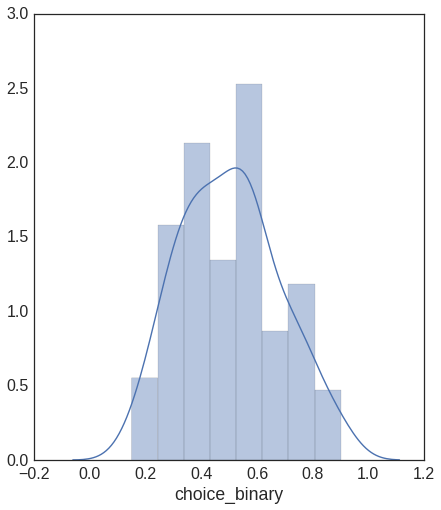

In [261]:
sns.distplot(perc_df['choice_binary'])

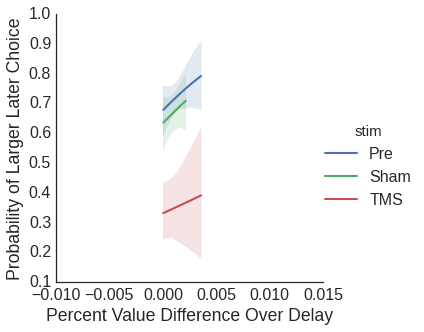

In [302]:
a = all_data.reset_index()
a['diff'] = (a['amountLL'] - a['amountSS'])/a['amountSS']
a['choice_LL'] = [int(not x) for x in a['choice_binary']]
a = a[a['cond'] == 'Magnitude']
sns.lmplot(x = 'k_eq', y = 'choice_LL', hue  = 'stim', logistic = True, 
           truncate  = True, units = 'sub', scatter = False, data = a)
plt.ylabel('Probability of Larger Later Choice')
plt.xlabel('Percent Value Difference Over Delay')

In [303]:
all_data

index  trial  amountSS  amountLL  delayLL choice  \
sub cond      stim hemi                                                      
01  Ctrl      Pre  LEFT       0      1     14.00     14.14       14     SS   
                   LEFT       1      2     15.00     15.15       14     SS   
                   LEFT       2      3     27.00     27.27       28     SS   
                   LEFT       3      4     19.00     19.95       28     SS   
                   LEFT       4      5     28.00     29.40       28     SS   
                   LEFT       5      6     25.00     33.00       28     LL   
                   LEFT       6      7     21.00     22.05       14     SS   
                   LEFT       7      8     22.00     26.40       28     SS   
                   LEFT       8      8     22.00     26.40       28     LL   
                   LEFT       9      9     20.00     22.00       28     LL   
                   LEFT      10     10     10.00     11.00       14     LL   
                   LEFT      11     11     14.00     19.60       14     LL   
                   LEFT      12     12     18.00     25.20       14     LL   
                   LEFT      13     13     22.00     26.40       14     SS   
                   LEFT      14     14     23.00     32.20       28     SS   
                   LEFT      15     15     14.00     21.00       28     LL   
                   LEFT      16     16     18.00     23.40       14     SS   
                   LEFT      17     17     11.00     14.30       28     SS   
                   LEFT      18     18     26.00     33.80       28     SS   
                   LEFT      19     19     15.00     22.50       14     LL   
                   LEFT      20     20     25.00     37.50       14     LL   
                   RIGHT      0      1     23.36     24.53       14     SS   
                   RIGHT      1      2     13.96     14.10       14     SS   
                   RIGHT      2      3     23.59     25.94       28     SS   
                   RIGHT      3      4     28.15     39.41       28     SS   
                   RIGHT      4      5     22.44     33.67       28     SS   
                   RIGHT      5      6     25.17     30.21       28     LL   
                   RIGHT      6      7     23.63     30.72       14     LL   
                   RIGHT      7      8     18.48     18.67       28     LL   
                   RIGHT      8      9     21.47     27.91       28     LL   
...                         ...    ...       ...       ...      ...    ...   
15  Magnitude Sham LEFT     170     11   2700.00   2808.00       28     LL   
                   LEFT     171     12   1400.00   1407.00       14     LL   
                   LEFT     172     13   1500.00   1501.50       28     LL   
                   LEFT     173     14   1800.00   1872.00       28     LL   
                   LEFT     174     15   2500.00   2502.50       14     LL   
                   LEFT     175     16   2900.00   2914.50       14     LL   
                   LEFT     176     17   2600.00   2652.00       28     LL   
                   LEFT     177     18   2400.00   2520.00       28     SS   
                   LEFT     178     19   2800.00   2940.00       28     LL   
                   LEFT     179     20   1700.00   1717.00       14     LL   
              TMS  LEFT     100      1   2300.00   2311.50       14     LL   
                   LEFT     101      2   2800.00   2802.80       14     LL   
                   LEFT     102      3   1500.00   1515.00       28     LL   
                   LEFT     103      4   1200.00   1248.00       28     LL   
                   LEFT     104      5   2600.00   2730.00       14     LL   
                   LEFT     105      6   2300.00   2346.00       28     LL   
                   LEFT     106      7   1300.00   1339.00       28     LL   
                   LEFT     107      8   2000.00   2002.00       14     SS   
                   LEFT     108      9   2700.00

In [ ]:
3